In [25]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
bos = load_boston()
data = bos.data
target = bos.target


In [12]:
df = pd.DataFrame(data, columns=bos.feature_names)
print(target[:10])
df.head()

[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9]


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [15]:
X = df
y = target

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
dtr = DecisionTreeRegressor()

In [19]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [20]:
y_train_pred = dtr.predict(X_train)
y_valid_pred = dtr.predict(X_valid)

In [22]:
print(f'train error: {mean_squared_error(y_train, y_train_pred)}')
print(f'valid error: {mean_squared_error(y_valid, y_valid_pred)}')

train error: 0.0
valid error: 18.770838323353292


In [23]:
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        self.base_score = self.metric(y_valid, self.model.predict(X_valid))
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            score = self.metric(y_valid, y_valid_pred)
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

In [28]:
pi = permutation_importance(dtr, mean_squared_error)

In [29]:
pi.compute(X_valid, y_valid)

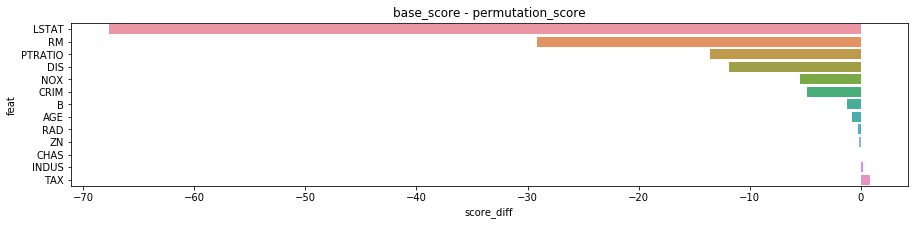

In [31]:
pi.show_permutation_importance()

In [32]:
good_feats = pi.get_negative_feature()
good_feats

['CRIM', 'ZN', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'PTRATIO', 'B', 'LSTAT']

In [17]:
dtr = DecisionTreeRegressor()

In [33]:
dtr.fit(X_train[good_feats], y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [35]:
y_train_pred = dtr.predict(X_train[good_feats])
y_valid_pred = dtr.predict(X_valid[good_feats])

In [36]:
print(f'train error: {mean_squared_error(y_train, y_train_pred)}')
print(f'valid error: {mean_squared_error(y_valid, y_valid_pred)}')

train error: 0.0
valid error: 16.795089820359287


In [37]:
 (18.770838323353292 - 16.795089820359287)/18.770838323353292


0.10525627406507063